<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Flemming/AML_IceCores_flemse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
!pip install pyyaml h5py 
!pip install umap-learn

Streaming af output blev afkortet til de sidste 5000 linjer.
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5515.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5516.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5517.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5518.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5519.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_552.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5520.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5521.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5522.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5523.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5524.png  
  inflating: Ins

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb

In [3]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
sup = training_set(sup_df, sup_im_path)

In [4]:
# save image_size
im_e, lab, feat = sup.__getitem__(147950)
image_size = im_e.shape[0]
image_size

128

In [5]:
lab

6

In [6]:
latent_dim = 64
image_size= 128
unit_n = 32

encoder_input = keras.Input(shape=(image_size,image_size,1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(x)
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.InputLayer(input_shape=latent_dim)(encoder_output)
x = keras.layers.Dense(units=unit_n*unit_n*32, activation=tf.nn.relu)(decoder_input)
x = keras.layers.Reshape(target_shape=(unit_n, unit_n, 32))(x)
x = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
x = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
# No activation
decoder_output = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=1, padding='same')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

encoder.compile(opt, loss='mse')
autoencoder.compile(opt, loss='mse')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 64)                3936320   
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 dense_1 (Dense)             (None, 32768)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

for i in range(5):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 1000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

Epoch 1/200
29/29 [==============================] - 20s 88ms/step - loss: 0.1211 - val_loss: 0.0433
Epoch 2/200
29/29 [==============================] - 1s 42ms/step - loss: 0.0396 - val_loss: 0.0349
Epoch 3/200
29/29 [==============================] - 1s 46ms/step - loss: 0.0305 - val_loss: 0.0286
Epoch 4/200
29/29 [==============================] - 1s 42ms/step - loss: 0.0276 - val_loss: 0.0259
Epoch 5/200
29/29 [==============================] - 1s 38ms/step - loss: 0.0240 - val_loss: 0.0217
Epoch 6/200
29/29 [==============================] - 1s 35ms/step - loss: 0.0191 - val_loss: 0.0167
Epoch 7/200
29/29 [==============================] - 1s 35ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 8/200
29/29 [==============================] - 1s 33ms/step - loss: 0.0139 - val_loss: 0.0131
Epoch 9/200
29/29 [==============================] - 1s 35ms/step - loss: 0.0121 - val_loss: 0.0119
Epoch 10/200
29/29 [==============================] - 1s 36ms/step - loss: 0.0111 - val_loss: 0.011

In [8]:
encoder.save('encoder')

INFO:tensorflow:Assets written to: encoder/assets


In [9]:
y_preds = encoder.predict(x_train)

In [10]:
map = umap.UMAP(n_components=2)
y = map.fit_transform(y_preds)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


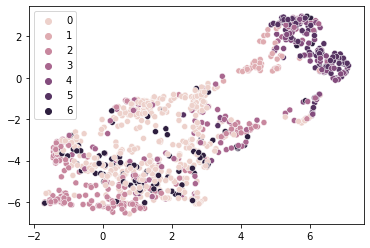

In [11]:
plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_train_lab)
plt.show()

Følgende træner på data hvor der mangler en class, aka label 0,1,2....5, 6
Bagefter prøver vi at lave en prediction på dataen. 

In [67]:
def tree_missingClass(n_class, n_i = 5, nr_ims = 1000, all_classes = False):
  tree = lgb.LGBMClassifier(objective='multiclass')

  for i in range(n_i):
    # create encoder training
    nr_tot_images = len(sup.labels)
    x_train = []
    x_train_lab = []
    x_train_feats = []
    rand_idx = np.arange(0,nr_tot_images)
    rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
    for i in range(nr_ims):
        im, lab, feat = sup.__getitem__(rand_idx[i])
        if lab != n_class or all_classes == True:
          x_train.append(im)
          x_train_lab.append(lab)
          x_train_feats.append(feat)
    x_train = np.array(x_train)
    x_train_lab = np.array(x_train_lab)
    x_train_feats = np.array(x_train_feats)


    y_preds = encoder.predict(x_train)

    x_train_with_encoded = []
    for i in range(len(y_preds)):
        inp = np.append(x_train_feats[i], y_preds[i])
        x_train_with_encoded.append(inp)
    x_train_with_encoded = np.array(x_train_with_encoded)
    
    tree.fit(x_train_with_encoded, x_train_lab)
    return tree

tree = tree_missingClass(0)

In [69]:
# create encoder training
def train(func): #Should have called it predict
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 1000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)

  y_pred = func.predict(x_train_with_encoded)
  return sum(y_pred==x_train_lab)/len(y_pred)



In [65]:
#y_pred = tree.predict(x_train_with_encoded)

In [66]:
#sum(y_pred==x_train_lab)/len(y_pred)

0.496

In [89]:
tree_all = train(tree_missingClass(0, all_classes = True))
tree_0 = train(tree_missingClass(0))
tree_1 = train(tree_missingClass(1))
tree_2 = train(tree_missingClass(2))
tree_3 = train(tree_missingClass(3))
tree_4 = train(tree_missingClass(4))
tree_5 = train(tree_missingClass(5))
tree_6 = train(tree_missingClass(6))

print(tree, tree_0, tree_1, tree_2, tree_3, tree_4, tree_5, tree_6)

0.822 0.469 0.739 0.605 0.775 0.753 0.794 0.813


Følgende gør det modsatte af før. Her træner vi på alt dataen, men når vi predicter fjerne vi en class aka label.

In [91]:
def predict_with_missing_lass(n_class, func, nr_ims = 1000, all_classes = False):
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      if lab != n_class or all_classes == True:
        x_train.append(im)
        x_train_lab.append(lab)
        x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)

  y_pred = func.predict(x_train_with_encoded)
  return sum(y_pred==x_train_lab)/len(y_pred)



In [92]:
test = tree_missingClass(0, all_classes = True)
pred_all = predict_with_missing_lass(0, test, all_classes = True)
pred_0 = predict_with_missing_lass(0, test)
pred_1 = predict_with_missing_lass(1, test)
pred_2 = predict_with_missing_lass(2, test)
pred_3 = predict_with_missing_lass(3, test)
pred_4 = predict_with_missing_lass(4, test)
pred_5 = predict_with_missing_lass(5, test)
pred_6 = predict_with_missing_lass(6, test)

print(pred_all, pred_0, pred_1, pred_2, pred_3, pred_4, pred_5, pred_6)

0.816 0.7154742096505824 0.8250265111346765 0.779874213836478 0.831096196868009 0.8173076923076923 0.8367567567567568 0.8529741863075196
